<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Reading-and-Exploring-the-Data" data-toc-modified-id="Reading-and-Exploring-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading and Exploring the Data</a></span><ul class="toc-item"><li><span><a href="#Numerical-Features-Analysis" data-toc-modified-id="Numerical-Features-Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Numerical Features Analysis</a></span></li><li><span><a href="#Categorical-Features-Analysis" data-toc-modified-id="Categorical-Features-Analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Categorical Features Analysis</a></span></li><li><span><a href="#Insights-from-Data" data-toc-modified-id="Insights-from-Data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Insights from Data</a></span></li><li><span><a href="#Clustering-Data" data-toc-modified-id="Clustering-Data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Clustering Data</a></span><ul class="toc-item"><li><span><a href="#Age-and-Duration" data-toc-modified-id="Age-and-Duration-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Age and Duration</a></span></li><li><span><a href="#Credit-Amount-and-Duration" data-toc-modified-id="Credit-Amount-and-Duration-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Credit Amount and Duration</a></span></li></ul></li></ul></li><li><span><a href="#Data-Prep" data-toc-modified-id="Data-Prep-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Prep</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-Pipeline" data-toc-modified-id="Preprocessing-Pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preprocessing Pipeline</a></span></li><li><span><a href="#Processing-Pipeline" data-toc-modified-id="Processing-Pipeline-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Processing Pipeline</a></span></li></ul></li><li><span><a href="#Training-and-Evaluating-a-Model" data-toc-modified-id="Training-and-Evaluating-a-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Evaluating a Model</a></span></li><li><span><a href="#Production-Script" data-toc-modified-id="Production-Script-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Production Script</a></span></li></ul></div>

Hi everyone! The _German Credit Risk_ dataset has been the first place I started my kaggle journey. As long as I've been studying Data Science and Machine Learning, I always saw Kaggle as one of the greates ways to learn more about everything related on these two topics. So here I am!

**UPDATE:** I just finished my "German Credit Risk Project" with a DevOps approach for training a Machine Learning model and scoring production data received for a source. The idea is to simulate what we get in practice. So if you want to take a look at it, please visit my github at [ThiagoPaniniGithub](https://github.com/ThiagoPanini/kaggle_challenges/tree/master/kernels/01_german_credit_risk) - you will see that the project strucuture have a `/dev`, `/models`, `/pipelines`, `´/prod` and other folders, simulating what I consider an organized Machine Learning project for real. The scripts we can pay attention is the `train.py` (for reading the data, building pipelines and training a model) and the `score.py` (for receiving new data, applying the pipelines and scoring the data using the trained model).

I really like you enjoy! At the end of this notebook you can see a little taste of it.

# Libraries

In [1]:
# Stsandard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time

# Utilities
from viz_utils import *
from ml_utils import *
from custom_transformers import *

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, \
                                    learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
    accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


# Reading and Exploring the Data

Here we will answear the following questions:
    - What's the content of data?
    - How are the numerical attributes distributed?
    - How are the categorical attributes distributed?
    - What's the influence of Risk and Credit Amount in other features?
    - Is there any other pattern that may be related to credit risk?

In [2]:
# Data path
df_ori = import_data('german_credit_data.csv', optimized=True)
df = df_ori.iloc[:, 1:]
df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]

# Results
print(f'Data dimension: {df.shape}')
df.head()

O dataset possui 11 colunas, das quais 5 são elegíveis a otimização.

----------------------------------------------------
Memória RAM utilizada (50 linhas): 0.0043 MB
Memória RAM após otimização (50 linhas): 0.0034 MB
----------------------------------------------------

Ganho de 22.08% em uso de memória!

Data dimension: (1000, 10)


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


___
* _Target class balance_
___

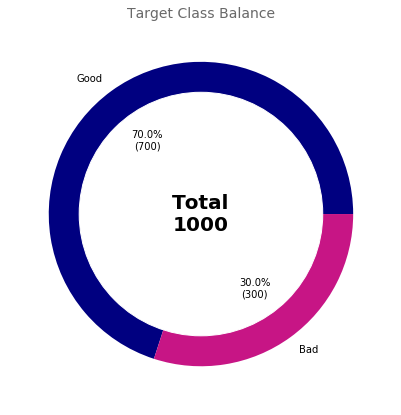

In [3]:
# Target class balance
fig, ax = plt.subplots(figsize=(7, 7))
label_names = ['Good', 'Bad']
color_list = ['navy', 'mediumvioletred']
text = f'Total\n{len(df_ori)}'
title = 'Target Class Balance'

# Visualizing it through a donut chart
donut_plot(df, col='risk', ax=ax, label_names=label_names, colors=color_list, title=title, text=text)

An overview of the data.

In [4]:
# Overview from the data
df_overview = data_overview(df)
df_overview

,feature,qtd_null,percent_null,dtype,qtd_cat
0,checking_account,394,0.394,object,3
1,saving_accounts,183,0.183,object,4
2,age,0,0.000,int32,0
3,sex,0,0.000,object,2
4,job,0,0.000,int32,0
5,housing,0,0.000,object,3
6,credit_amount,0,0.000,int32,0
7,duration,0,0.000,int32,0
8,purpose,0,0.000,object,8
9,risk,0,0.000,object,2


## Numerical Features Analysis

___
* _Distribution_
___

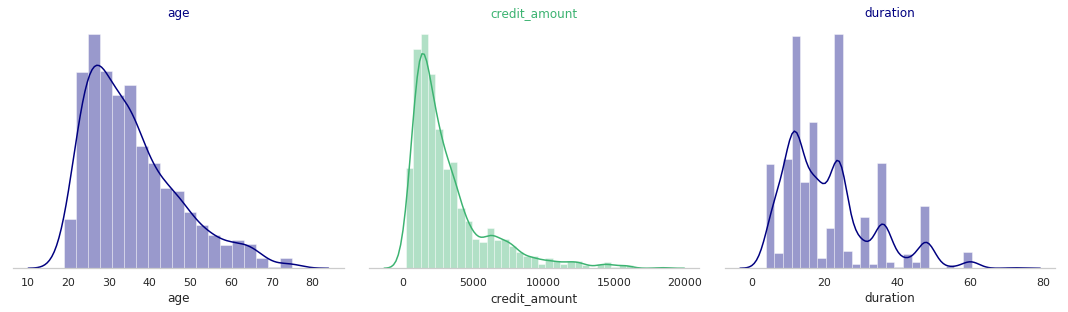

In [5]:
num_cols = ['age', 'credit_amount', 'duration']
color_sequence = ['navy', 'mediumseagreen', 'navy']
numplot_analysis(df[num_cols], color_sequence=color_sequence, hist=True)
plt.show()

___
* _Distribution by risk_
___

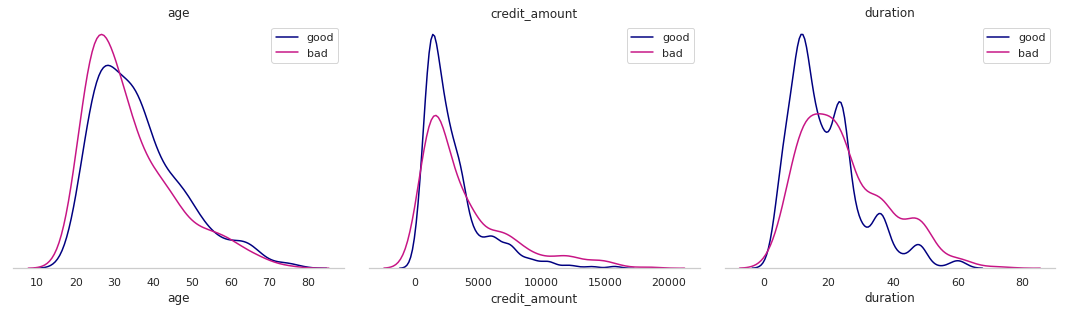

In [6]:
num_cols += ['risk']
numplot_analysis(df[num_cols], hue='risk', color_hue=color_list)

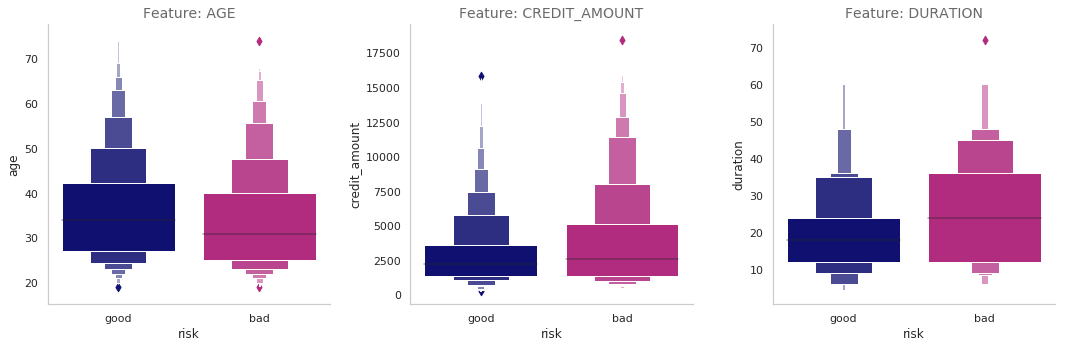

In [7]:
boxenplot(df, features=['age', 'credit_amount', 'duration'], hue='risk', fig_cols=3, figsize=(15, 5), 
          palette=color_list)

By looking at the the plots above, it's reasonble to point that:

* **Young people tend to present more risk than the older ones**
    * To me this statement makes sense because maybe older people usually have more financial stability than the younger ones;
    * By the perspective of a bank or a loan establishment, probably it's safer to offer better credit programs to people who has condition to pay back.
    
    
* **Higher credit amount presents more risk than lower ones**
    * Well, this is kind of intuitive and makes total sense to me;
    * By the perspective of a customer who took a loan or entered a credit program, it's easier to pay back a low amount.
    
    
* **Higher duration is related to a higher risk**
    * Once again this is perfectly fine to say;
    * The common credit programs are based on interest or fees that gets higher through the time;
    * A costumer who took money for a long time will have to pay much more by the end.

## Categorical Features Analysis

___
* _Quantity for each category_
___

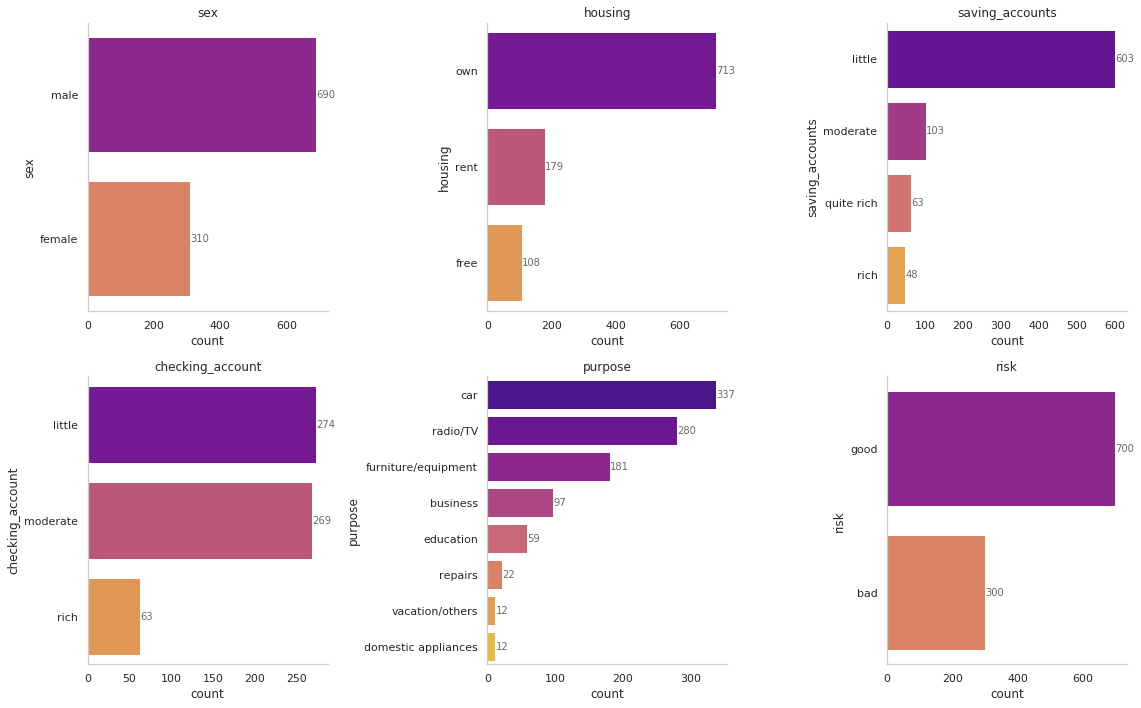

In [8]:
cat_features = [col for col, dtype in df.dtypes.items() if dtype == 'object']
catplot_analysis(df[cat_features], palette='plasma')

These categorical analysis provided an overview of our dataset in terms of quantity. For each categorical column, now is possible to know what are the marjority ones. Meanwhile, to give more power to the analysis, let's separate each categorical entry into the risk approach.

___
* _Quantity for each category by risk_
___

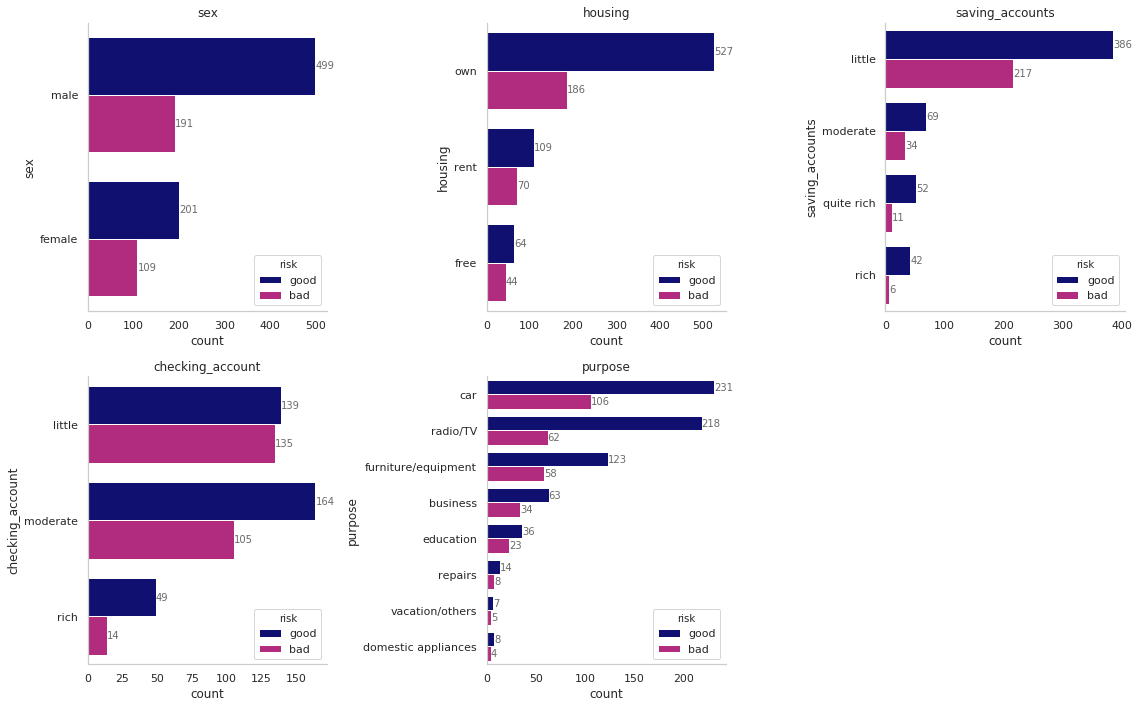

In [9]:
catplot_analysis(df[cat_features], hue='risk', palette=color_list)

On the first look, maybe the main category that demands some attention if `checking_account`. If we look at those ones with _little_ checking account and its distribution by risk, it's almost 50/50. To make it cleaner for us to conclude, let's repeat this analysis but in a percentage approach.

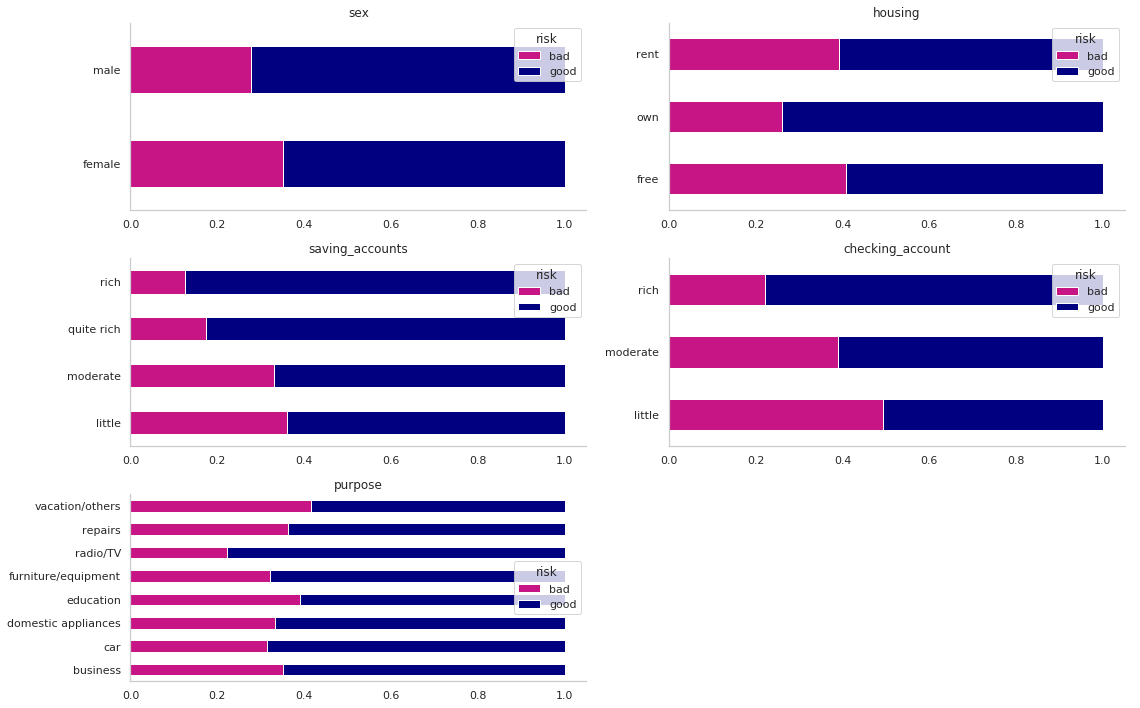

In [10]:
rev_color_list = ['mediumvioletred', 'navy']
catplot_percentage_analysis(df[cat_features], hue='risk', palette=rev_color_list)

The insights we can take from the plot above are:

* People with `little` saving account and checking account presents higher risk;
* When customers take some credit for `vacation/others`, it's a sign that the risk could be high;
* People who have their own house have lower risk

## Insights from Data

In this session we will go deeper into the dataset to make some graphical analysis in order to take valuable insights that could be used on understanding the problem or even on training a model.

___
* _For what purpose people tend to apply for higher amount loans in average? In terms of total amount, what's the main purpose?_
___

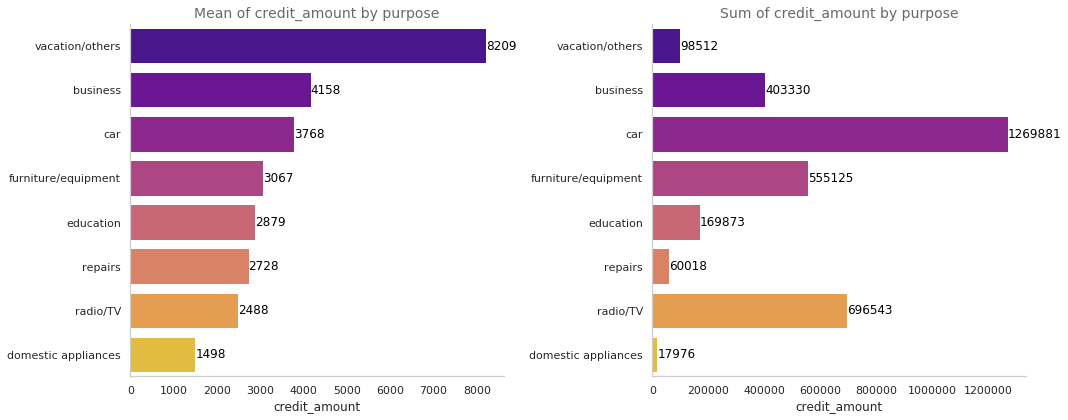

In [11]:
mean_sum_analysis(df, group_col='purpose', value_col='credit_amount')

We could see by the graphic that, in average, people often request higher credit amount for `vacation/other`. Meanwhile this purpose is only the 6th in terms of total amount given by the loan establishment.

By the way, people who request credit for `car` purpose representes the main public for the bank/loan establishment.

___
* _Is there any purpose in particular with long duration credit requests?_
___

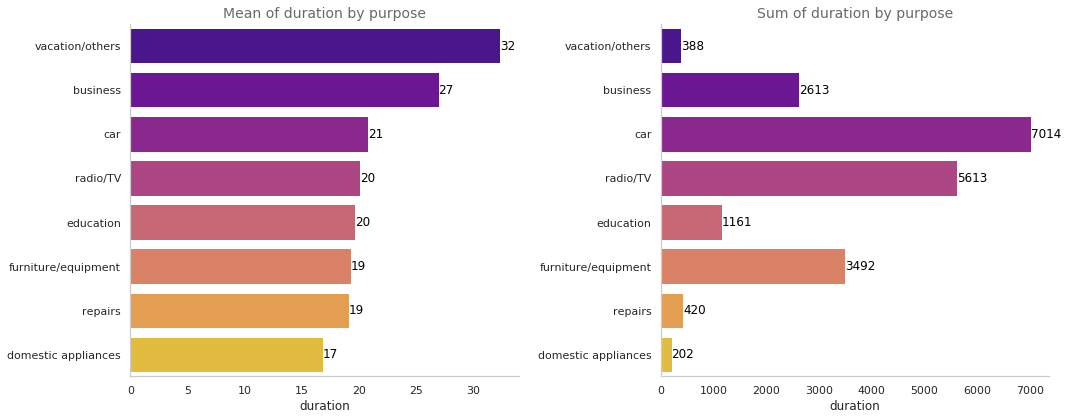

In [12]:
mean_sum_analysis(df, group_col='purpose', value_col='duration')

___
* _How credit amount is related to gender?_
___

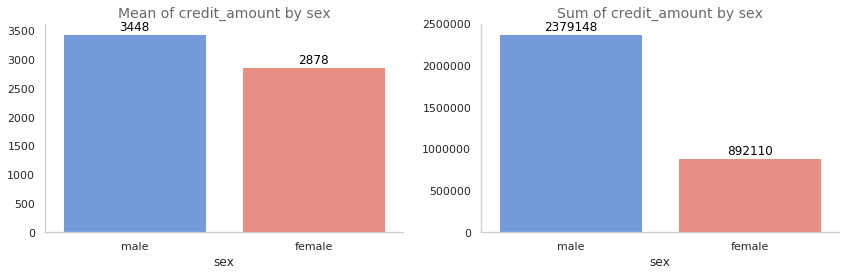

In [13]:
gender_palette = ['cornflowerblue', 'salmon']
mean_sum_analysis(df, group_col='sex', value_col='credit_amount', orient='horizontal', 
                  palette=gender_palette, figsize=(12, 4))

___
* _Is there any correlation between features?_
___

For this let's use the `pairplot` function from `seaborn`.

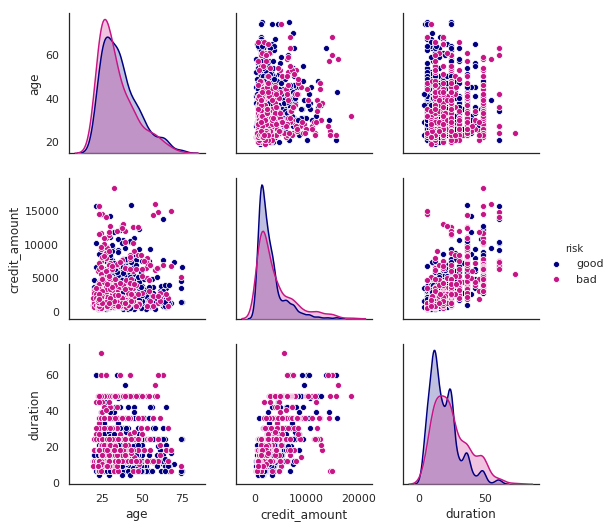

In [14]:
sns.pairplot(df[num_cols], hue='risk', palette=color_list)
plt.show()

The scatterplots built into the `pairplot` function show us that maybe there is a positive correlation between `credit amount` and `duration` of the credit request. It makes sense, since long term credits could be related to higher amounts.

___
* _How much credit was given for bad risk customers?_
___

Just to clarify, this is a really important question by the way. The answear we search here is to see the profile of the bank/credit stablishment in terms of risk.

In [15]:
amount_risk = df.groupby(by='risk', as_index=False).sum().loc[:, ['risk', 'credit_amount']]
amount_risk['percentage'] = amount_risk['credit_amount'] / amount_risk['credit_amount'].sum()
amount_risk.style.background_gradient(cmap='Reds_r')

,risk,credit_amount,percentage
0,bad,1181438,0.361157
1,good,2089820,0.638843


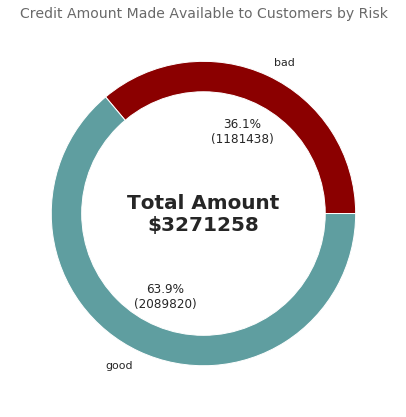

In [16]:
# Creating figure
fig, ax = plt.subplots(figsize=(7, 7))

# Defining useful elements for the donut chart
values = amount_risk['credit_amount']
labels = amount_risk['risk']
center_circle = plt.Circle((0, 0), 0.8, color='white')

# Plotting the pizza chart and the center circle
ax.pie(values, labels=labels, colors=['darkred', 'cadetblue'], autopct=make_autopct(values))
ax.add_artist(center_circle)

kwargs = dict(size=20, fontweight='bold', va='center')
ax.text(0, 0, f'Total Amount\n${values.sum()}', ha='center', **kwargs)
ax.set_title('Credit Amount Made Available to Customers by Risk', size=14, color='dimgrey')
plt.show()

___
* _Analysing how housing and job attributes is related to age and credit amount_
___

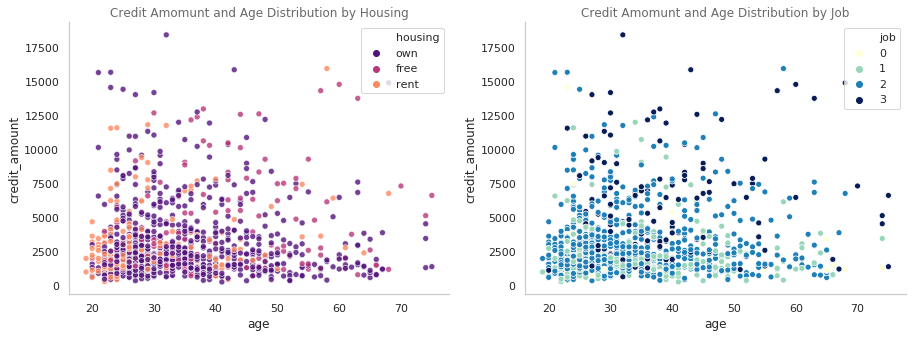

In [17]:
# Creating figure
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# Scatterplot
sns.scatterplot(x='age', y='credit_amount', data=df, hue='housing', ax=axs[0], palette='magma', alpha=.8)
sns.scatterplot(x='age', y='credit_amount', data=df, hue='job', ax=axs[1], palette='YlGnBu')

# Customizing plot
format_spines(axs[0], right_border=False)
format_spines(axs[1], right_border=False)
axs[0].set_title('Credit Amomunt and Age Distribution by Housing', size=12, color='dimgrey')
axs[1].set_title('Credit Amomunt and Age Distribution by Job', size=12, color='dimgrey')
plt.show()

___
* _How the duration of loan requests are associated with age and credit amount?_
___

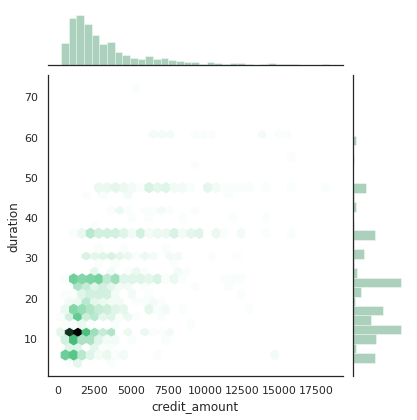

In [18]:
g = (sns.jointplot(x='credit_amount', y='duration', data=df, color='seagreen', kind='hex'))

Let's create bins for duration and see its behavior along a age and credit amount scatterplot

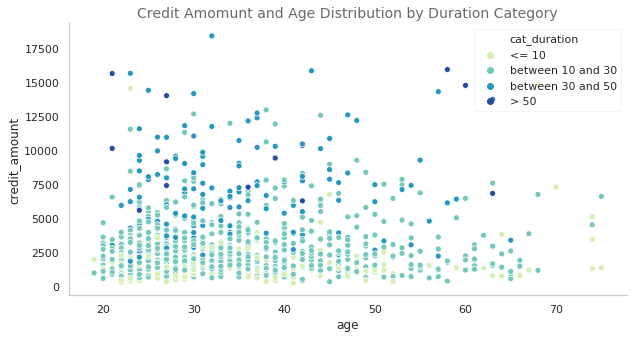

In [19]:
# Creating new categories for duration col
bins = [0, 10, 30, 50, np.inf]
labels = ['<= 10', 'between 10 and 30', 'between 30 and 50', '> 50']
df['cat_duration'] = pd.cut(df['duration'], bins=bins, labels=labels)

# Creating figure
fig, ax = plt.subplots(figsize=(10, 5))

# Scatterplot
sns.scatterplot(x='age', y='credit_amount', data=df, hue='cat_duration', palette='YlGnBu')

# Customizing plot
format_spines(ax, right_border=False)
ax.set_title('Credit Amomunt and Age Distribution by Duration Category', size=14, color='dimgrey')
ax.legend(loc='upper right', fancybox=False, framealpha=0.2)
df.drop('cat_duration', axis=1, inplace=True)
plt.show()

## Clustering Data

In this session, we will select some useful features to split the data into different clusters. The aim is to present a better way to understanding the relationship between features and to study how our public could be splitted into clusters.

### Age and Duration

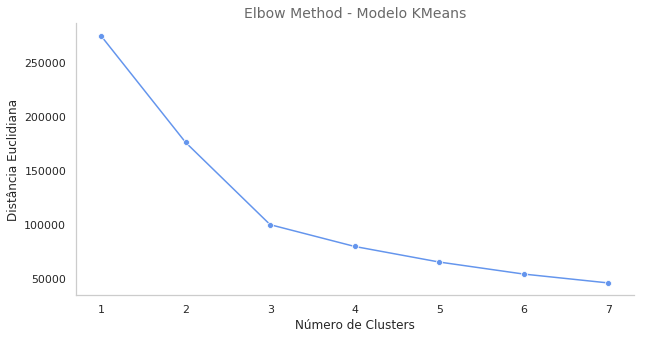

In [20]:
# Definindo melhor número de clusters
columns = ['age', 'duration']
cluster_data = df.loc[:, columns]
K_min, K_max = 1, 8
elbow_method_kmeans(cluster_data, K_min, K_max)

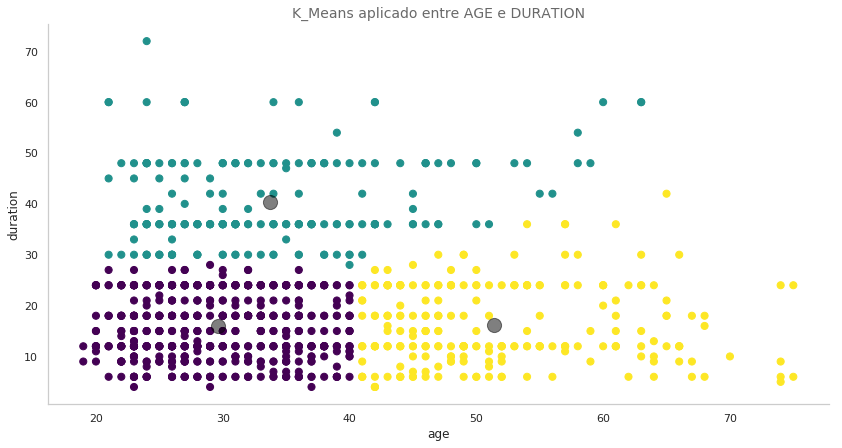

In [21]:
# Treinando algoritmo KMeans
k_means = KMeans(n_clusters=3)
k_means.fit(cluster_data)
y_kmeans = k_means.predict(cluster_data)
centers = k_means.cluster_centers_

# Plotando resultado do agrupamento
plot_kmeans_clusters(cluster_data, y_kmeans, centers, cmap='viridis')

It's really interesting to see the three main group on the data when we look at `age` and `duration` features. To present you some description with that I thought on:

* **Group 1 (purple):** Here we have young people (from 18 to 40 years approximately) who usually request short term loans (from 0 to 30 years approximately).

* **Group 2 (yellow):** On the cluster above the others, we have people who take loans for a long time (higher than 30 years).

* **Group 3 (green):** The third cluster have older people (with age higher than 40) and short term loans.

### Credit Amount and Duration

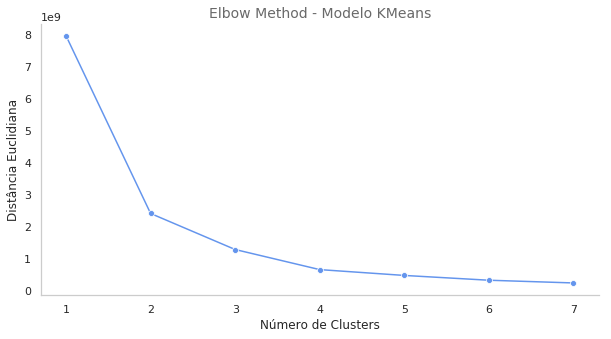

In [22]:
# Definindo melhor número de clusters
columns = ['credit_amount', 'duration']
cluster_data = df.loc[:, columns]
K_min, K_max = 1, 8
elbow_method_kmeans(cluster_data, K_min, K_max)

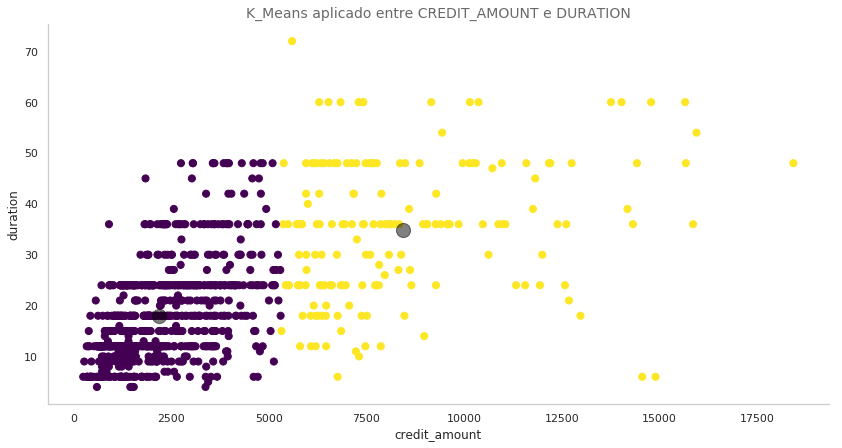

In [23]:
# Treinando algoritmo KMeans
k_means = KMeans(n_clusters=2)
k_means.fit(cluster_data)
y_kmeans = k_means.predict(cluster_data)
centers = k_means.cluster_centers_

# Plotando resultado do agrupamento
plot_kmeans_clusters(cluster_data, y_kmeans, centers, cmap='viridis')

Now we are using the `duration` and `credit_amount` features. The elbow method showed us that 2 is optimal number of clusters that we can get between these two features. So we have:

* **Group 1 (purple):** On this cluster we have customers who take lower amount for credit for a middle term duration (between 0 and 50 years).

* **Group 2 (yellow):** This cluster shows us customers that request higher amount for credit for a usually higher duration.

# Data Prep

After a pool of visualizations build in order to help us to get insights from the data, we can now safely go through the steps needed to prepare our data to a predictive model.

For this session, I prepared a utility model called `custom_transformers.py` with some classes already built right for this task.

In [24]:
# Creating a target column
df['target'] = df['risk'].apply(lambda x: 1 if x == 'bad' else 0)
df.drop('risk', axis=1, inplace=True)
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,target
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


## Preprocessing Pipeline

In this topic, I purpose the application of a preprocessing Pipeline to:

    - Remove duplicated instances;
    - Splitting data into train and test sets.

In [25]:
# Building the preprocessing Pipeline
preprocessing_pipeline = Pipeline([
    ('dup_dropped', DropDuplicates()),
    ('data_splitter', SplitData(target='target'))
])

# Applying this pipeline
X_train, X_test, y_train, y_test = preprocessing_pipeline.fit_transform(df)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (800, 9)
Shape of X_test: (200, 9)


## Processing Pipeline

In this step, the point is to construct pipelines for numerical and categorical data so we can:

**Numerical pipeline:**
    - Filling null data (if exists)
    - Scalling with StandardScaler
    
**Categorical pipeline:**
    - Filling null data (if exists - and we already know that it exists)
    - Apply encoding (with get_dummies)

In [26]:
# Splitting the data by dtype
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']
cat_features = [col for col, dtype in X_train.dtypes.items() if dtype == 'object']

# Building a numerical pipeline
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Building a categorical pipeline
cat_pipeline = Pipeline([
    ('encoder', DummiesEncoding(dummy_na=True))
])

# Building a complete pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [27]:
# Applying the data prep pipeline
X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.fit_transform(X_test)

print(f'Shape of X_train_prep: {X_train_prep.shape}')
print(f'Shape of X_test_prep: {X_test_prep.shape}')

Shape of X_train_prep: (800, 29)
Shape of X_test_prep: (200, 29)


In [28]:
# Returning the final features of the dataset
encoded_features = full_pipeline.named_transformers_['cat']['encoder'].features_after_encoding
model_features = num_features + encoded_features
df_train_prep = pd.DataFrame(X_train_prep, columns=model_features)
df_train_prep.head()

,age,job,credit_amount,duration,sex_female,sex_male,sex_nan,housing_free,housing_own,housing_rent,...,checking_account_nan,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others,purpose_nan
0,2.406187,0.107048,1.199912,3.297082,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.224364,0.107048,-0.359630,-0.008051,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.266282,0.107048,-0.733547,-1.279256,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.575104,0.107048,0.567050,-0.008051,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.276585,0.107048,-0.854388,-0.770774,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Training and Evaluating a Model

It seems we finally have a final dataset to analyze a classifying model. Our goal here is to use the features we prepared to predict the loan risk and, for that, we will go through evaluation metrics, ROC Curve, Confusion Matrix and other tools to show how good our models really are.

First let's setup all the hyperparmeters for the classifiers we pretend to evaluate

In [29]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees hyperparameters
tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# Random Forest hyperparameters
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [42],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

# LightGBM hyperparameters
lgbm_param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
}

lgbm_fixed_params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

At least, let's prepare a dictionary with the instances of our classifiers and the respective hyperparameters

In [30]:
# Setting up classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'DecisionTrees': {
        'model': DecisionTreeClassifier(),
        'params': tree_param_grid
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': forest_param_grid
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(**lgbm_fixed_params),
        'params': lgbm_param_grid
    }
}

___
* _Training and evaluating classifiers_
___

In [31]:
# Creating an instance for the homemade class BinaryClassifiersAnalysis
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train_prep, y_train, random_search=True, cv=5, verbose=5)

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished


Training model DecisionTrees

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model RandomForest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


Training model LightGBM

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


In [32]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train_prep, y_train, X_test_prep, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

Evaluating model LogisticRegression

Evaluating model DecisionTrees

Evaluating model RandomForest

Evaluating model LightGBM



,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.7387,0.6043,0.3983,0.4791,0.7544,0.137
1,LogisticRegression,Teste,0.755,0.6316,0.4068,0.4948,0.7525,0.003
2,DecisionTrees,Treino 5 K-folds,0.6712,0.4664,0.5894,0.5197,0.6347,0.078
3,DecisionTrees,Teste,0.675,0.4634,0.6441,0.539,0.6608,0.003
4,RandomForest,Treino 5 K-folds,0.7263,0.6516,0.1991,0.3023,0.7596,18.427
5,RandomForest,Teste,0.745,0.7222,0.2203,0.3377,0.7823,0.071
6,LightGBM,Treino 5 K-folds,0.7326,0.5671,0.4404,0.4936,0.7526,4.893
7,LightGBM,Teste,0.78,0.6744,0.4915,0.5686,0.799,0.006


___
* _Looking at the feature importance of a specific model_
___

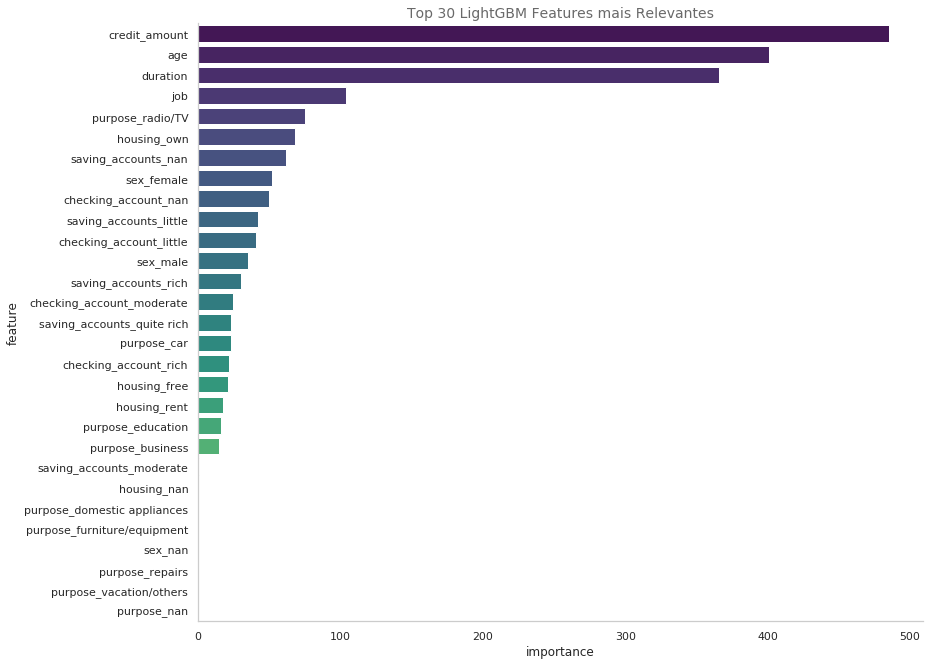

In [33]:
fig, ax = plt.subplots(figsize=(13, 11))
lgbm_feature_importance = clf_tool.feature_importance_analysis(model_features, specific_model='LightGBM', ax=ax)
plt.show()

___
* _Plotting the ROC Curve for the classifiers (train and test)_
___

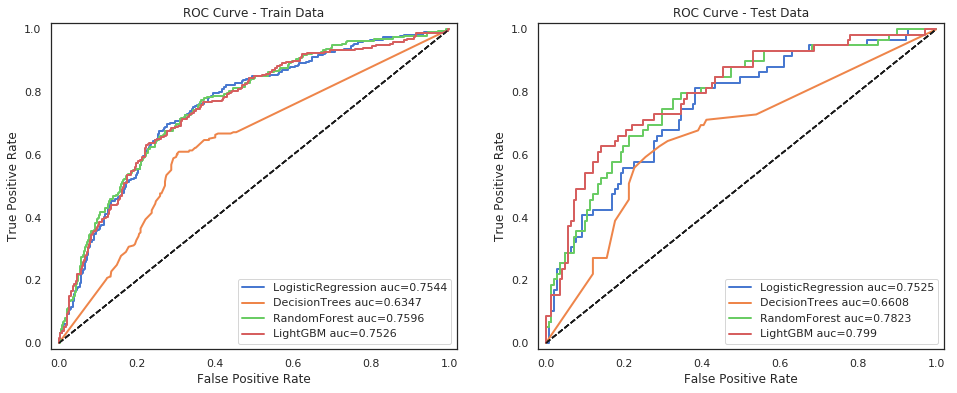

In [34]:
clf_tool.plot_roc_curve()

___
* _Plotting Confusion Matrix for each classifier (train and test)_
___

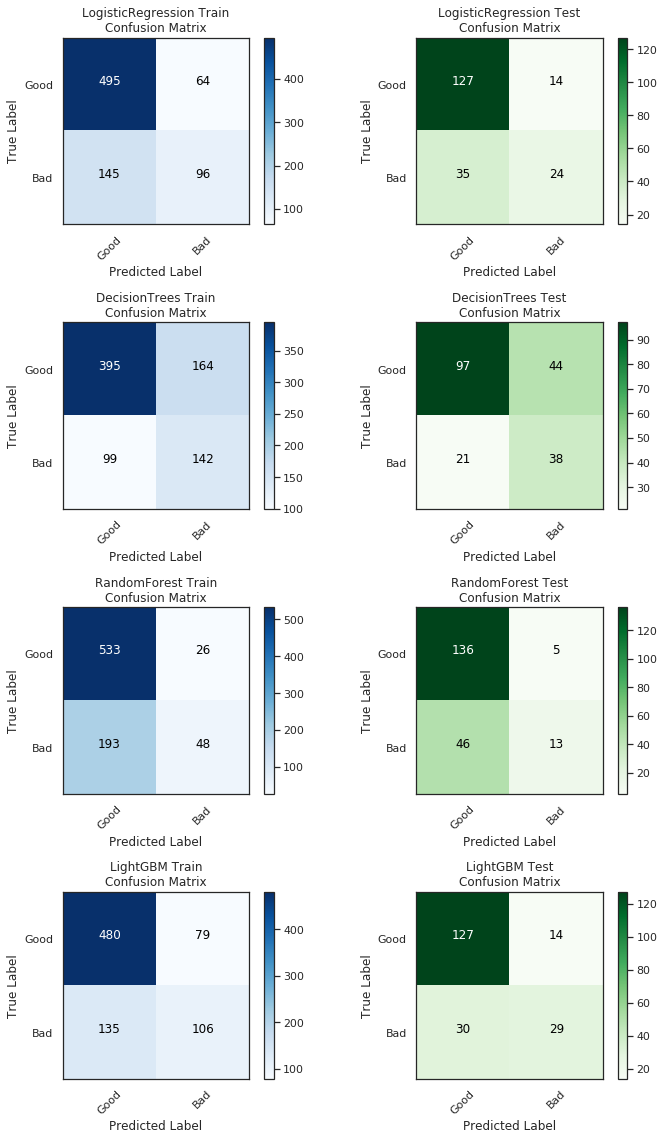

In [35]:
clf_tool.plot_confusion_matrix(classes=['Good', 'Bad'])

___
* _Learning curve for a specific model_
___

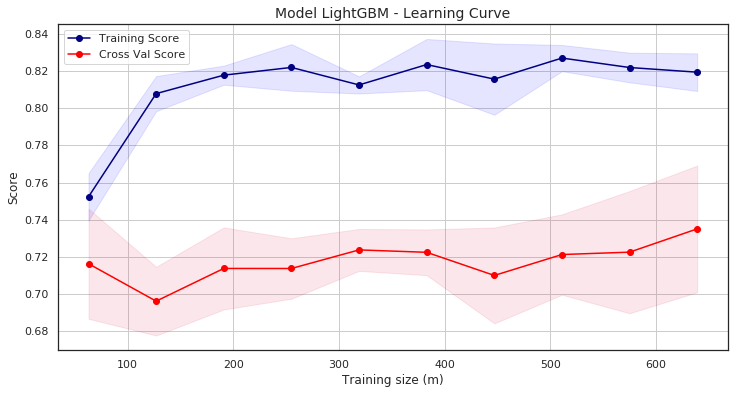

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
clf_tool.plot_learning_curve('LightGBM', ax=ax)
plt.show()

___
* _Looking at score (proba) distribution for a specific model_
___

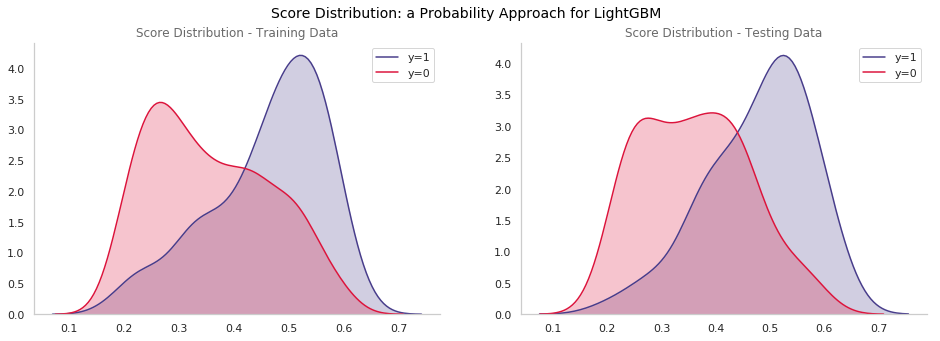

In [37]:
clf_tool.plot_score_distribution('LightGBM', shade=True)

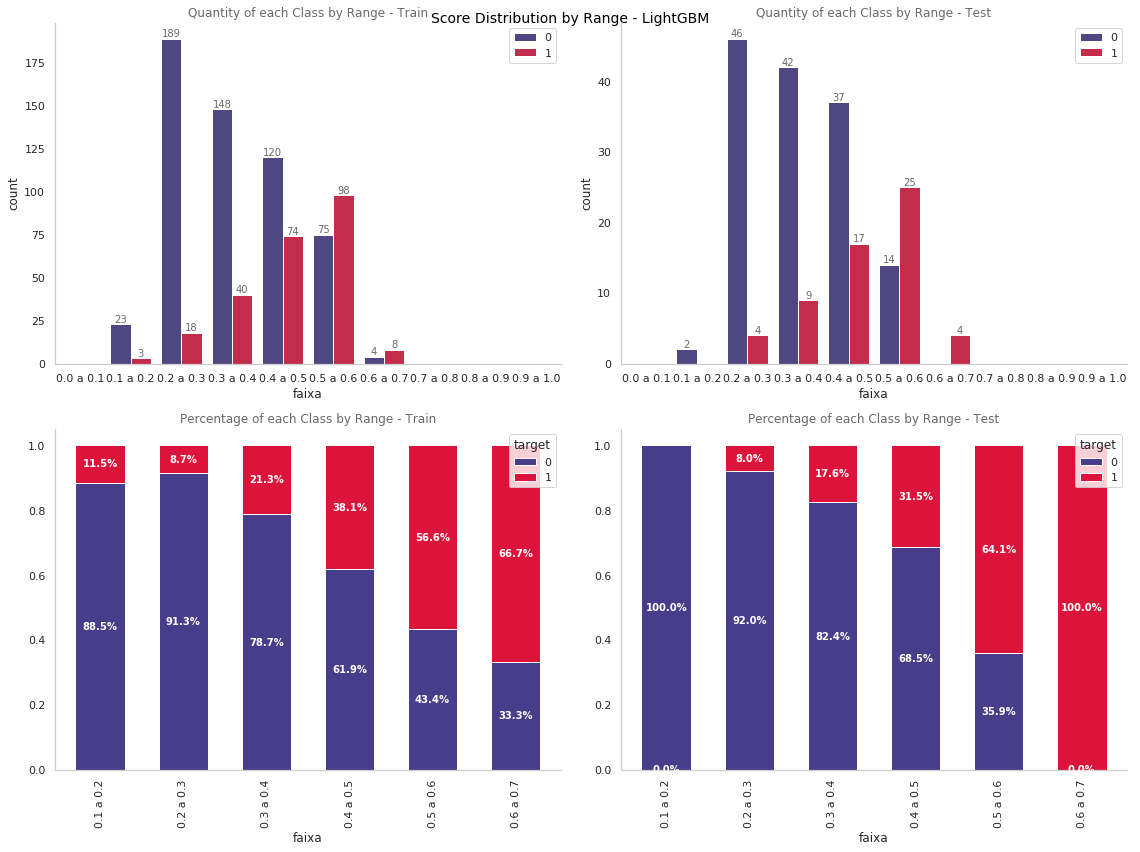

In [38]:
clf_tool.plot_score_bins('LightGBM', bin_range=0.1)

By looking at the graphs and the model results, it seems we've done a good work on preparing and training the data. By the end, the model LightGBM showd us the best performance among the classifiers used on analysis. Meanwhile, the model **learning curve** shows us that there is space for improvement: the high gap between training scores and validation scores is a proxy that the model could is overfitting the data and so we could work on that to raise up the validation score metric.

For the next steps, thinking on putting this model on production, we could encapsulate every step in a pipeline and build a python script to receive some entrance base and return the instance score or the instance prediction based on the business problem.

# Production Script

Let's imagine that we have already trained and selected the best model for this task. After that, we receive new data for scoring and we want to use our built pipeline to make this process easier. So, considering the data we have is the same we would use for scoring, the script could be constructed as:

In [39]:
# Libs
import pandas as pd
from custom_transformers import *
from sklearn.pipeline import Pipeline

# Reading the raw data
df_ori = import_data('./german_credit_data.csv', optimized=True)
df = df_ori.iloc[:, 1:]
df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]
df['target'] = df['risk'].apply(lambda x: 1 if x == 'bad' else 0)
df.drop('risk', axis=1, inplace=True)

# Applying the data prep pipeline (the pkl file could be read from a specific path)
scoring_data = full_pipeline.fit_transform(df)

# Using the trained model for predicting (the pkl file could be read from a specific path)
model = clf_tool.classifiers_info['LightGBM']['estimator']
y_pred = model.predict(scoring_data)
y_score = model.predict_proba(scoring_data)[:, 1]

# Appending the predictions to the data
df['y_score'] = y_score
df['y_pred'] = y_pred
df['y_class'] = df['y_pred'].apply(lambda x: 'Bad' if x == 1 else 'Good')

# Creating bins
bins = df['y_score'].quantile(np.arange(0, 1.01, 0.1)).values
labels = ['Faixa ' + str(i) for i in range(len(bins)-1, 0, -1)]
df['faixa'] = pd.cut(df['y_score'], bins=bins, labels=labels, include_lowest=True)
df.head()

O dataset possui 11 colunas, das quais 5 são elegíveis a otimização.

----------------------------------------------------
Memória RAM utilizada (50 linhas): 0.0043 MB
Memória RAM após otimização (50 linhas): 0.0034 MB
----------------------------------------------------

Ganho de 22.08% em uso de memória!



,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,target,y_score,y_pred,y_class,faixa
0,67,male,2,own,NaN,little,1169,6,radio/TV,0,0.255346,0,Good,Faixa 9
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,0.573986,1,Bad,Faixa 1
2,49,male,1,own,little,NaN,2096,12,education,0,0.238517,0,Good,Faixa 9
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,0.598501,1,Bad,Faixa 1
4,53,male,2,free,little,little,4870,24,car,1,0.569857,1,Bad,Faixa 1
